In [9]:
import math
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchdyn.core import NeuralODE

In [10]:
###
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

In [28]:
S40 = pd.read_csv("data/station_40.csv")
S49 = pd.read_csv("data/station_49.csv")
S63 = pd.read_csv("data/station_63.csv")
S80 = pd.read_csv("data/station_80.csv")

S40.rename(columns=lambda x: x + "_40" if x != "YEAR" else x, inplace=True)
S49.rename(columns=lambda x: x + "_49" if x != "YEAR" else x, inplace=True)
S63.rename(columns=lambda x: x + "_63" if x != "YEAR" else x, inplace=True)
S80.rename(columns=lambda x: x + "_80" if x != "YEAR" else x, inplace=True)

merged_df = pd.merge(S40, S49, on='YEAR', how='inner')
merged_df = pd.merge(merged_df, S63, on='YEAR', how='inner')
dataset = pd.merge(merged_df, S80, on='YEAR', how='inner')

dataset.set_index('YEAR', inplace=True)
target = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
features = [x for x in dataset.columns if x not in target]

print(dataset.shape)
dataset.head()

(10000, 76)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_10_80,W_11_80,W_12_80,W_13_80,W_14_80,W_15_80,W_16_80,W_17_80,W_18_80,YIELD_80
YEAR,,,,,,,,,,,,,,,,,,,,,
0,21.389266,26.985066,23.813756,26.852214,25.096705,26.852109,25.730293,23.416002,21.038240,5.739711,...,1.027391,1.228816,1.324273,2.309497,2.917570,0.769869,0.907157,3.401885,1.037317,10.51
1,21.314074,22.516442,24.072042,29.159849,29.522392,26.567033,28.249854,24.606161,19.268685,1.891106,...,0.143191,0.925005,2.751680,1.196560,0.784046,1.505209,0.240757,1.617603,1.818209,6.61
2,20.875083,26.038845,24.516708,27.633776,26.951667,27.926496,26.534607,25.968638,23.554623,4.745318,...,0.942601,1.811827,2.923051,0.384716,2.876004,1.535451,1.509938,1.652338,0.279352,6.86
3,20.553688,20.992986,22.859027,28.654018,26.705206,24.458350,25.146936,21.531644,22.961974,8.479863,...,3.640015,0.956474,2.241502,1.893830,0.189264,2.049275,3.795690,0.404447,1.468172,5.32
4,21.523342,21.542900,23.034072,26.327315,30.362289,27.503657,27.839165,29.764479,18.290963,3.405621,...,1.191167,0.049557,0.330440,2.860207,0.399063,0.506497,1.700047,0.216837,2.166599,6.32


In [29]:
dataset['Q40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])
dataset['Q49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])
dataset['Q63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])
dataset['Q80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])

features = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
aux_columns = ['Q40', 'Q49', 'Q63', 'Q80']
nb_weather_var = len([x for x in dataset.columns if not (x in features or x in aux_columns) ])

dataset = dataset[(dataset['Q40'] <= 6.4897) & (dataset['Q49'] <= 3.3241) & (dataset['Q63'] <= 7.1301) & (dataset['Q80'] <= 5.1292)]
print(dataset.shape)
dataset.head()

(1000, 80)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_14_80,W_15_80,W_16_80,W_17_80,W_18_80,YIELD_80,Q40,Q49,Q63,Q80
YEAR,,,,,,,,,,,,,,,,,,,,,
1,21.314074,22.516442,24.072042,29.159849,29.522392,26.567033,28.249854,24.606161,19.268685,1.891106,...,0.784046,1.505209,0.240757,1.617603,1.818209,6.61,5.747702,2.854533,5.236944,3.485815
2,20.875083,26.038845,24.516708,27.633776,26.951667,27.926496,26.534607,25.968638,23.554623,4.745318,...,2.876004,1.535451,1.509938,1.652338,0.279352,6.86,3.710861,1.335289,6.969746,4.796171
10,23.464658,23.112057,27.032350,26.348370,26.635686,27.142812,30.421238,24.051925,18.585785,0.692692,...,0.174179,2.236641,0.175408,2.514701,2.153090,6.04,4.228033,2.324025,5.944738,2.984735
28,24.495898,23.278987,23.563798,27.221256,25.471418,28.230339,27.622846,23.942648,20.273115,2.315491,...,1.527473,0.417273,0.691531,2.872908,1.997046,6.08,4.314756,1.687566,4.366588,2.287822
33,22.954317,23.373752,24.817940,26.166261,28.014204,29.420747,27.174332,26.733400,20.511923,0.827020,...,0.158058,0.958499,2.007874,0.499257,4.017396,3.51,3.791783,3.147831,3.363723,1.652700


<AxesSubplot: >

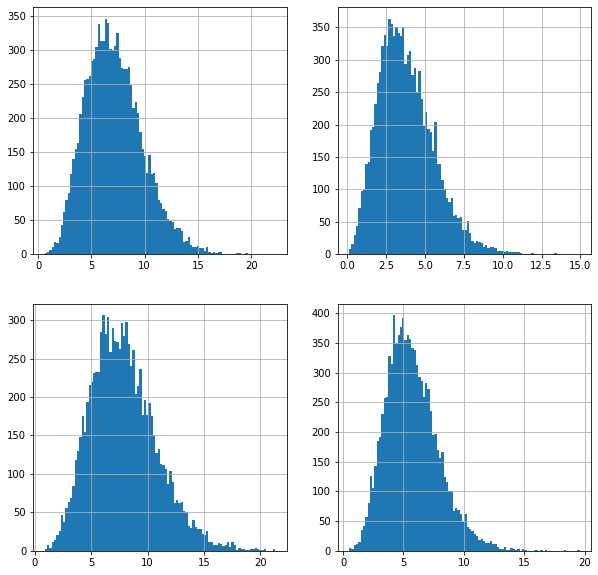

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(221)
dataset['Q40'].hist(bins=100)
plt.subplot(222)
dataset['Q49'].hist(bins=100)
plt.subplot(223)
dataset['Q63'].hist(bins=100)
plt.subplot(224)
dataset['Q90'].hist(bins=100)

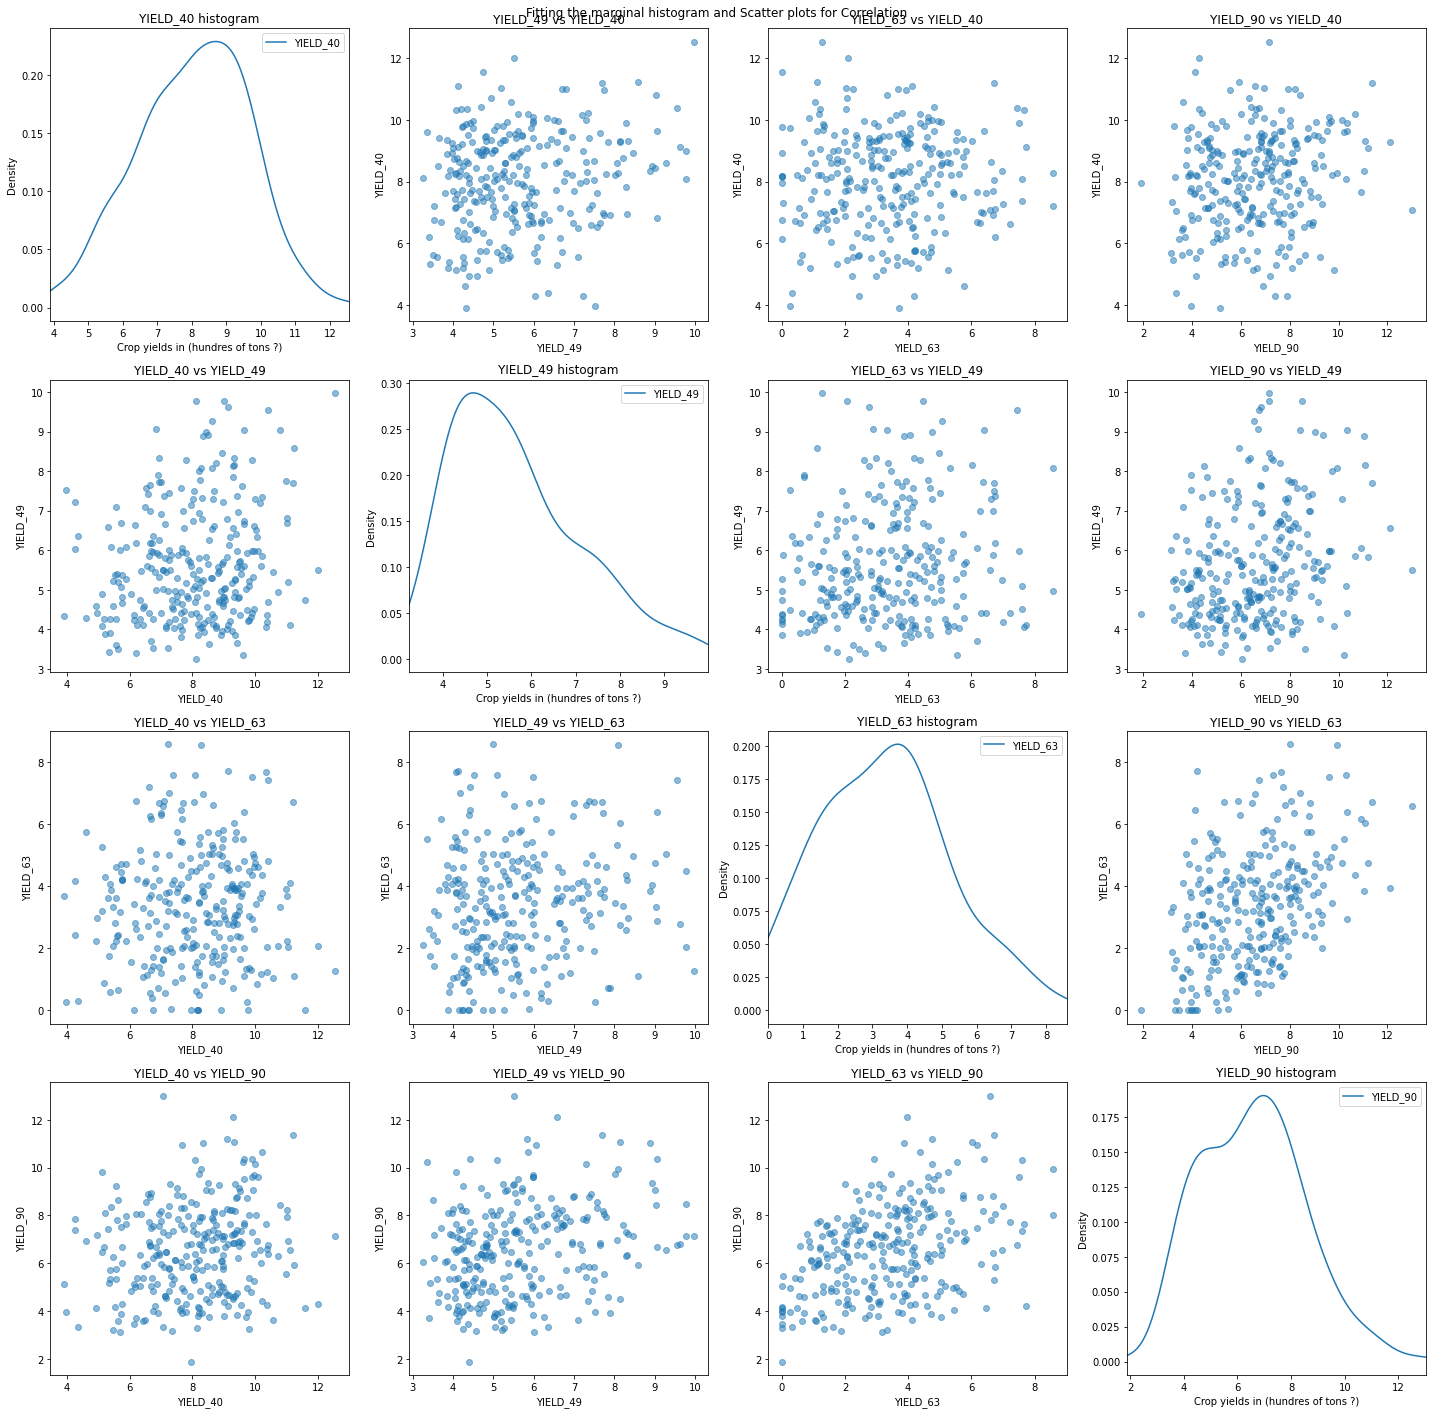

In [5]:
# Use only the YIELD data :
X= dataset[['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90']]

# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(len(X.columns)):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    X[yield_ind].plot.density()
    mu, std = X[yield_ind].mean(), X[yield_ind].std()
    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = X.iloc[:, i]
            y = X.iloc[:, j]

            plt.scatter(x, y, alpha=0.5)
            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


# Flow matching directly on the yields :

200: loss 1.480 time 3.22
400: loss 0.971 time 4.12
600: loss 0.831 time 5.10
800: loss 1.070 time 6.03
1000: loss 0.828 time 6.91
1200: loss 0.741 time 7.77
1400: loss 0.994 time 8.64
1600: loss 0.881 time 9.68
1800: loss 0.794 time 10.67
2000: loss 0.786 time 11.66


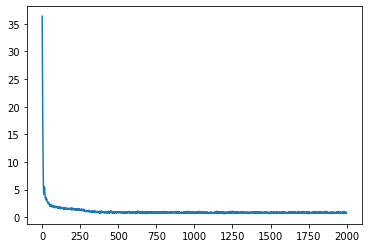

In [6]:
sigma = 0.1
dim = 4
batch_size = 256
model = MLP(dim=dim, time_varying=True, w=128)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(2000):
    optimizer.zero_grad()

    x0 = torch.rand([batch_size,dim], dtype=torch.float32)
    x1 = torch.tensor(X.sample(n=batch_size, random_state=np.random.seed(seed)).values, dtype=torch.float32)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)

In [7]:
nb_samples = 289

with torch.no_grad():
        node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        x0 = torch.rand([nb_samples,dim], dtype=torch.float32)
        traj = node.trajectory(
                x0,
                t_span=torch.linspace(0, 1, 100),
                )
        samples = pd.DataFrame(traj[-1].cpu().numpy())

print(samples.shape)

(289, 4)


# Flow matching on the temperature then on the yields conditionaly on the temperature

In [8]:
weather = dataset[[x for x in dataset.columns if x not in ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90', 'Q40', 'Q49', 'Q63', 'Q90']]]

200: loss 2.866 time 2.23
400: loss 2.627 time 3.96
600: loss 2.130 time 5.80
800: loss 1.613 time 7.61
1000: loss 1.281 time 9.42
1200: loss 1.118 time 11.34
1400: loss 1.036 time 13.03
1600: loss 1.020 time 15.11
1800: loss 0.895 time 17.02
2000: loss 0.931 time 18.82
2200: loss 0.873 time 20.59
2400: loss 0.830 time 22.45
2600: loss 0.736 time 24.85
2800: loss 0.855 time 27.33
3000: loss 0.764 time 29.70
3200: loss 0.840 time 31.94
3400: loss 0.835 time 33.92
3600: loss 0.779 time 36.24
3800: loss 0.793 time 38.64
4000: loss 0.792 time 40.70
4200: loss 0.753 time 42.82
4400: loss 0.732 time 44.94
4600: loss 0.716 time 47.37
4800: loss 0.721 time 49.75
5000: loss 0.663 time 51.82


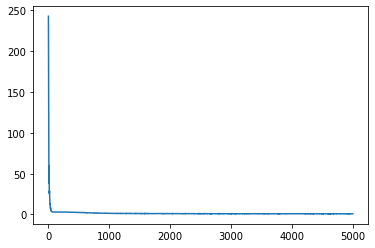

In [9]:
weather_dim = weather.shape[1]
batch_size = 256
weather_model = MLP(dim=weather_dim, time_varying=True, w=256)
optimizer = torch.optim.Adam(weather_model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(5000):
    optimizer.zero_grad()

    w0 = torch.rand([batch_size,weather_dim], dtype=torch.float32)
    w1 = torch.tensor(weather.sample(n=batch_size, random_state=np.random.seed(seed)).values, dtype=torch.float32)

    t, wt, ut = FM.sample_location_and_conditional_flow(w0, w1)

    vt = weather_model(torch.cat([wt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)

200: loss 0.861 time 5.27
400: loss 0.528 time 10.51
600: loss 0.339 time 15.98
800: loss 0.357 time 21.10
1000: loss 0.260 time 25.93
1200: loss 0.158 time 30.19
1400: loss 0.155 time 34.33
1600: loss 0.131 time 38.99
1800: loss 0.137 time 44.09
2000: loss 0.110 time 49.23
2200: loss 0.134 time 54.17
2400: loss 0.124 time 58.38
2600: loss 0.093 time 62.58
2800: loss 0.098 time 66.72
3000: loss 0.085 time 70.60


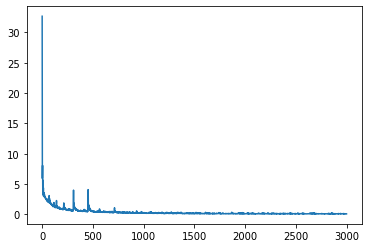

In [10]:

class MLP(torch.nn.Module):
    def __init__(self, dim, cond_dim=0, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + cond_dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )
        self.cond_dim = cond_dim

    def forward(self, x):
        return torch.cat((self.net(x), torch.zeros((x.shape[0], self.cond_dim))), dim=1)

yields_dim = 4
batch_size = 256
cond_model = MLP(dim=yields_dim, cond_dim=weather_dim, time_varying=True, w=502)
optimizer = torch.optim.Adam(cond_model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(3000):
    optimizer.zero_grad()

    x0 = torch.rand([batch_size,yields_dim], dtype=torch.float32)

    data = dataset.sample(n=batch_size, random_state=np.random.seed(seed))
    x1 = torch.tensor(data[features].values, dtype=torch.float32)
    w1 = torch.tensor(data[[x for x in dataset.columns if not (x in features or x in aux_columns)]].values, dtype=torch.float32)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = cond_model(torch.cat([xt, w1, t[:, None]], dim=-1))
    loss = torch.mean((vt[:,:4] - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)

In [11]:
def sample_weather(weather_model, batch_size):
    node = NeuralODE(torch_wrapper(weather_model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    w0 = torch.rand([batch_size,weather_dim], dtype=torch.float32)
    traj = node.trajectory(
            w0,
            t_span=torch.linspace(0, 1, 100),
            )
    return traj[-1]

def sample_yields(weather_model, cond_model, batch_size):
    weather_conds = sample_weather(weather_model, batch_size)
    node = NeuralODE(torch_wrapper(cond_model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    rand = torch.rand((batch_size,yields_dim), dtype=torch.float32)
    x0 = torch.cat([rand, weather_conds], dim=1)
    print(x0.shape)
    traj = node.trajectory(
            x0,
            t_span=torch.linspace(0, 1, 100),
            )
    return traj[-1]

samples2 = pd.DataFrame(sample_yields(weather_model, cond_model, 1000).detach())

torch.Size([1000, 76])


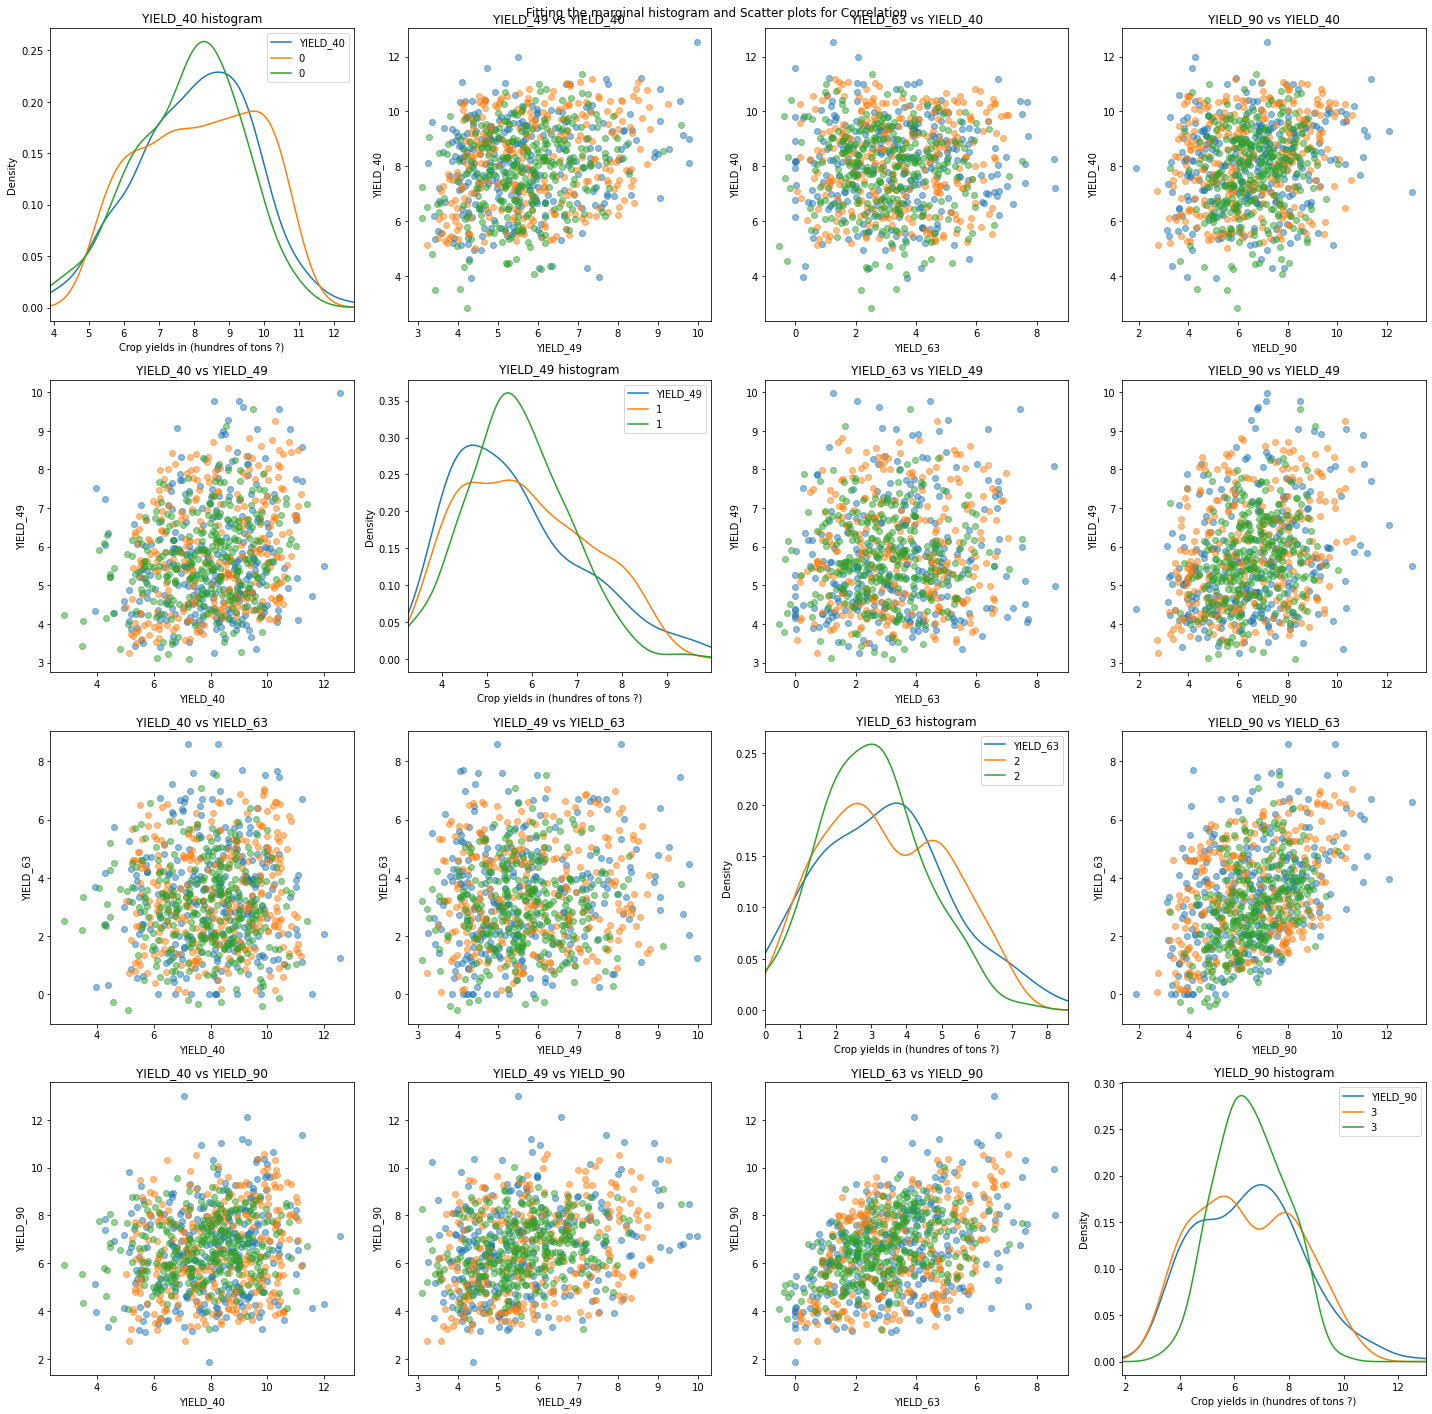

In [ ]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(4):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    X[yield_ind].plot.density()
    samples[k].plot.density()
    samples2[k].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(4):
    for j in range(4):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)
            
            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = samples2.iloc[:, i]
            y = samples2.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

#Blue = True data
#Orange = First method 
#Green = Second method
